In [1]:
using Revise

In [2]:
using
    QuantumStates,
    OpticalBlochEquations,
    DifferentialEquations,
    UnitsToValue,
    LinearAlgebra,
    Printf,
    Plots,
    Random,
    StatsBase,
    Distributions,
    StructArrays,
    StaticArrays,
    StructArrays,
    LoopVectorization,
    Parameters,
    MutableNamedTuples

@consts begin
    λ = 626e-9
    Γ = 2π * 6.4e6
    m = @with_unit 57 "u"
    k = 2π / λ
    _μB = (μ_B / h) * 1e-4
    kB = 1.380649e-23
end
;

In [3]:
ground_state1 = AngularMomentumState_Labelled(L=0, N=1, M=-1)
ground_state2 = AngularMomentumState_Labelled(L=0, N=1, M= 0)
ground_state3 = AngularMomentumState_Labelled(L=0, N=1, M=+1)
excited_state = AngularMomentumState_Labelled(L=1, N=0, M= 0)
basis = [ground_state1; ground_state2; ground_state3; excited_state]
;

In [4]:
# create Hamiltonian
operator = :(
    T * L +
    Bz * Zeeman_L0
)

parameters = @params begin
    T = 4.789016900958466e14
    Bz = 1e-6
end

H = Hamiltonian(basis=basis, operator=operator, parameters=parameters)
;

In [5]:
# solve the Hamiltonian
evaluate!(H)
QuantumStates.solve!(H)
states = H.states

# calculate the transition dipole moments
update_basis_tdms!(H)
update_tdms!(H)
d = H.tdms
;

In [353]:
# beam parameters
s = 1000
ω0 = 2π * energy(H.states[4])
Δ = +15Γ

ϵ_func(ϵ) = t -> ϵ
s_func(s) = (r,t) -> s

ω1 = ω0 + Δ; k1 = +x̂; ϵ1 = rotate_pol(σ⁺, k1); laser1 = Field(k1, ϵ_func(ϵ1), ω1, s_func(s))
ω2 = ω0 + Δ; k2 = -x̂; ϵ2 = rotate_pol(σ⁺, k2); laser2 = Field(k2, ϵ_func(ϵ2), ω2, s_func(s))
ω3 = ω0 + Δ; k3 = +ŷ; ϵ3 = rotate_pol(σ⁺, k3); laser3 = Field(k3, ϵ_func(ϵ3), ω3, s_func(s))
ω4 = ω0 + Δ; k4 = -ŷ; ϵ4 = rotate_pol(σ⁺, k4); laser4 = Field(k4, ϵ_func(ϵ4), ω4, s_func(s))
ω5 = ω0 + Δ; k5 = +ẑ; ϵ5 = rotate_pol(σ⁺, k5); laser5 = Field(k5, ϵ_func(ϵ5), ω5, s_func(s))
ω6 = ω0 + Δ; k6 = -ẑ; ϵ6 = rotate_pol(σ⁺, k6); laser6 = Field(k6, ϵ_func(ϵ6), ω6, s_func(s))

lasers = [laser1, laser2, laser3, laser4, laser5, laser6]
;

In [354]:
using LoopVectorization
function update_H_and_∇H(H, p, r, t)
    
    # Define a ramping magnetic field
    Zeeman_Hz = p.extra_data.Zeeman_Hz
    Bz = p.sim_params.B_offset[3]
    
    @turbo for i in eachindex(H)
        H.re[i] = Bz * Zeeman_Hz.re[i]
        H.im[i] = Bz * Zeeman_Hz.im[i]
    end
    
    ∇H = SVector{3, Float64}(0,0,0)
    
    return ∇H
end
;

In [355]:
Zeeman_z(state, state′) = Zeeman_L0(state, state′, 0)
Zeeman_z_mat = StructArray(operator_to_matrix_zero_padding2(Zeeman_z, [H.states[1], H.states[2]], [H.states[3]]) .* (2π*gS*_μB/Γ))

extra_data = MutableNamedTuple(
    # Zeeman_Hx = Zeeman_x_mat,
    # Zeeman_Hy = Zeeman_y_mat,
    Zeeman_Hz = Zeeman_z_mat,
    lasers = lasers,
    states = states
)
sim_params = MutableNamedTuple(
    B_offset = (0., 0., 0.)
    )
;

In [396]:
# Set initial conditions
particle = Particle()

ρ0 = zeros(ComplexF64, length(states), length(states))
ρ0[4,4] = 1.0

freq_res = 1e-1
p = obe(ρ0, particle, states, lasers, d, true, true; 
    sim_params=sim_params, extra_data=extra_data, λ=λ, Γ=Γ, freq_res=freq_res, update_H_and_∇H=update_H_and_∇H)

p.r0 = (0., 0., 0.) .* 2π
p.v = (200., 200., 0.) ./ (Γ / k)
p.v = round_vel(p.v, p.freq_res)

t_end = 10p.period
tspan = (0., t_end)

# prob.p.force_last_period = (0, 0, 0)
cb = PeriodicCallback(reset_force!, p.period)

prob = ODEProblem(ρ_updated!, p.ρ0_vec, tspan, p, callback=cb)
times = range(0, t_end, 10000)
;

In [397]:
# using BenchmarkTools
# dρ = deepcopy(p.ρ0_vec)
# @btime ρ_updated!($dρ, $p.ρ0_vec, $p, 0.0)

In [398]:
@time sol = DifferentialEquations.solve(prob, DP5(), reltol=1e-4, saveat=times) #, maxiters=1e7)
;

  0.066924 seconds (4.13 k allocations: 2.286 MiB)


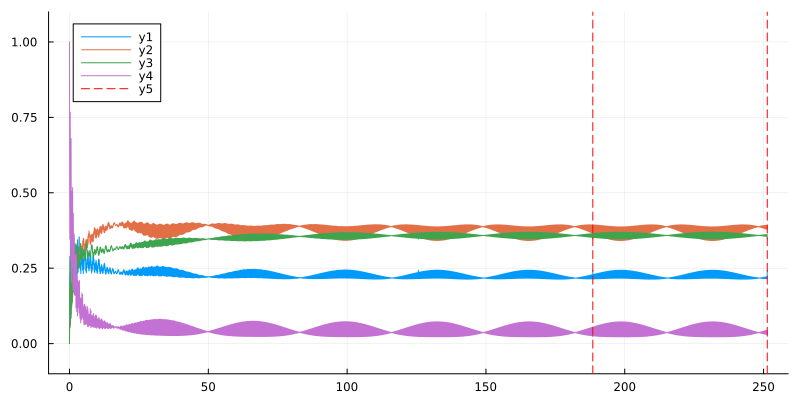

In [399]:
using Plots
plot_us = sol.u#[1:100:end]
plot_ts = sol.t#[1:100:end]

n_states = size(prob.p.ρ_soa, 1)
plot(size=(800, 400), ylim=(-0.1, 1.1))
for i in 1:n_states
    state_idx = n_states*(i-1) + i
    plot!(plot_ts, [real(u[state_idx]) for u in plot_us])
end
# plot()
# plot!(plot_ts, [real(u[end]) for u in plot_us])
# plot!(plot_ts, [real(u[end-1]) for u in plot_us])
# plot!(plot_ts, [real(u[end-2]) for u in plot_us])
plot!()
offset = 0
vline!([sol.t[end] - prob.p.period - offset, sol.t[end] - offset], color="red", linestyle=:dash)
# vline!([280, 380], color="red", linestyle=:dash)

In [400]:
prob.p.ρ_soa |> diag |> sum

0.9999999999999971 + 0.0im

In [401]:
prob.p.force_last_period #* (1e-3 * ħ * k * Γ / m)

3-element SVector{3, Float64} with indices SOneTo(3):
 -0.5772356035410232
  0.5810548119823772
 -0.008896763812266966

In [402]:
prob.p.populations

4-element Vector{ComplexF64}:
 0.22367549911603118 + 0.0im
   0.376008934279804 + 0.0im
  0.3584003770902903 + 0.0im
  0.0419151895138533 + 0.0im

## Force versus velocity

In [362]:
function prob_func(prob, i, repeat)
    prob.p.v = (scan_params[i].v, scan_params[i].v, 0)
    prob.p.force_last_period = SVector(0.,0.,0.)
    return prob
end
function output_func(sol, i)
    f = sol.prob.p.force_last_period
    return (f, false) #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [366]:
using RectiGrids

di = 0
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = (-100:1:100) #./ (Γ / k)

scan_values = (r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
scan_params = scan_values_grid
;

In [367]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params), reltol=1e-4, save_on=false)
;

  2.383911 seconds (94.27 k allocations: 12.648 MiB, 6.16% compilation time)


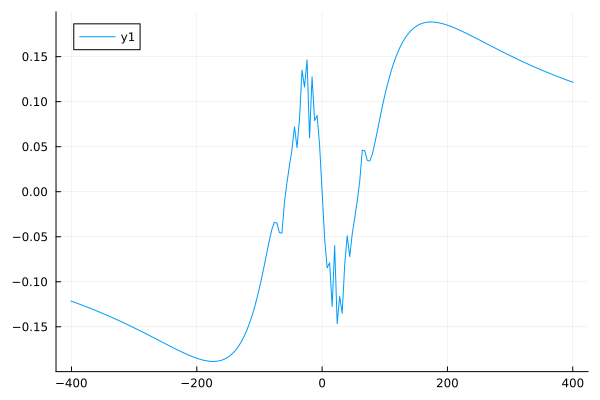

In [405]:
plot(vs .* (Γ / k), [sol.prob.p.force_last_period[2] for sol ∈ ensemble_sol] .* 2)

## Force versus magnetic field

In [179]:
function prob_func(prob, i, repeat)
    
    prob.p.v = scan_params[i].v
    prob.p.force_last_period = SVector(0.,0.,0.)
    
    # Solve Hamiltonian for new `Bz` value
    prob.p.sim_params.B_offset = (0, 0, scan_params[i].Bz)
    
    return prob
end
function param_func(prob, scan_values, i)
    return scan_values.Bz[i]
end
function output_func(sol, i)
    f = sol.prob.p.force_last_period
    return (f, false) #[3] #(f ⋅ p.v) / norm(p.v)
end
;

In [2600]:
using RectiGrids

Bs = -700:20:700
di = 0
rs = vcat([(n1/(di+1), n2/(di+1), n3/(di+1)) .* 2π for n1 ∈ 0:di, n2 ∈ 0:di, n3 ∈ 0:di]...)
vs = [(0., 0., 0.)]; #[sample_direction(0.1) for _ in 1:10]

scan_values = (Bz = Bs, r = rs, v = vs)
scan_values_grid = RectiGrids.grid(scan_values)
;

In [2601]:
scan_params = scan_values_grid
;

In [2602]:
ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
@time ensemble_sol = solve(ensemble_prob, DP5(), EnsembleThreads(), trajectories=length(scan_params), reltol=1e-4, save_on=false)
;

  2.549804 seconds (101.65 k allocations: 9.287 MiB, 46.01% compilation time: 9% of which was recompilation)


In [2603]:
[sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol]

71-element Vector{Float64}:
  0.4726164993677521
  0.04392450135520325
  0.025402585041259376
 -0.23597450879480614
  0.057043929415509266
  0.05501839347183036
  0.004772460523943004
 -0.12414008362762079
 -0.4473538766157928
 -0.03364235052408915
  0.059731249322618675
  0.07774881014430114
  0.049973842179530006
  ⋮
 -0.07774834219639648
 -0.05973166203980948
  0.03364268871366954
  0.44735290126043764
  0.12414218054534357
 -0.004767973019901229
 -0.05502278088047197
 -0.0570397375724814
  0.23597451363353583
 -0.02540671001257888
 -0.04392369525673196
 -0.4726141802749244

In [2604]:
forces = [sol.prob.p.force_last_period[3] for sol ∈ ensemble_sol]
;

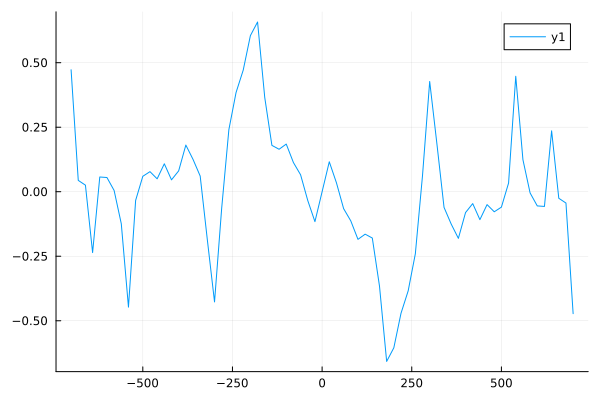

In [2605]:
plot(Bs, forces)